In [1]:
import pandas as pd

blood_ptau = pd.read_csv('/Users/larsheijnen/Thesis/data/blood/BLOOD_DATE_FORMATTED_CSF_FILTERED_PTAU.csv')

In [2]:
# Find PATNOs with exactly 5 occurrences
patnos_with_5_visits = blood_ptau['PATNO'].value_counts()
patnos_with_5_visits = patnos_with_5_visits[patnos_with_5_visits == 5].index.tolist()

print("PATNOs with 5 visits:", patnos_with_5_visits)

PATNOs with 5 visits: [3528, 3771, 41568, 92490, 3775, 41288, 3527, 51689, 16580, 3116, 51782, 14281, 3530, 3009, 60003, 41523, 3854, 51392, 51440, 41522, 40338, 60074, 3130, 3305, 41526, 51540, 41529, 3127, 51551, 41562, 52678, 4135, 51867, 52275, 3100, 3088, 60057, 3028, 4058, 4109, 3515, 41578, 52523, 50044, 60065, 3325, 52400, 3027, 42171, 50225, 52524, 52530, 3106, 52062, 3831, 60035, 3358, 3908, 3360, 3112, 3522, 3793, 4123, 4100, 51330, 41519, 41486, 4071, 40725, 3564, 50319, 50509, 41382, 4072, 40704, 3226, 3615, 50455, 3171, 50379, 40713, 3607, 3224, 3212, 3223, 40754, 3175, 3593, 3592, 3591, 40776, 3572, 3029, 3584, 40882, 40893, 3900, 54144, 50860, 3960, 3478, 40587, 3480, 3274, 51186, 41412, 3414, 41410, 3665, 3664, 40602, 40603, 3417, 3967, 3260, 60100, 3190, 3430, 3634, 3476, 53988, 3635, 3653, 3054]


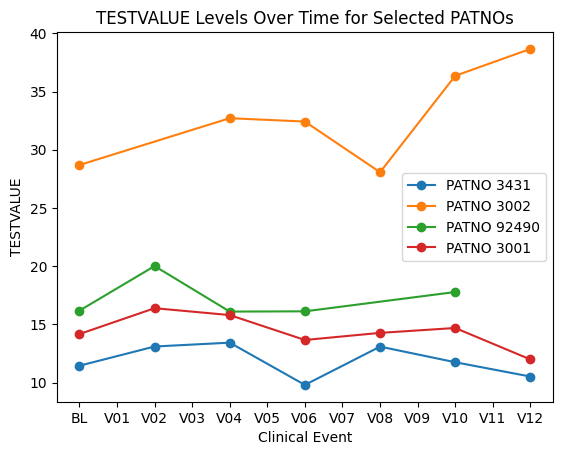

In [3]:
import matplotlib.pyplot as plt

# Define the function to plot the data
def plot_patnos(df, patnos):
    # Define the event order and mapping
    event_order = ['BL'] + [f'V{i:02d}' for i in range(1, 13)]  # Adjust range as needed
    event_map = {event: idx for idx, event in enumerate(event_order)}

    # Filter the data for the specified PATNOs
    filtered_data = df[df['PATNO'].isin(patnos)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the temporal change for each PATNO
    for patno in patnos:
        patient_data = filtered_data[filtered_data['PATNO'] == patno].copy()
        patient_data['TESTVALUE'] = pd.to_numeric(patient_data['TESTVALUE'], errors='coerce')
        patient_data['order'] = patient_data['CLINICAL_EVENT'].astype(str).map(event_map)
        patient_data = patient_data.dropna(subset=['order']).sort_values(by='order')
        ax.plot(patient_data['order'], patient_data['TESTVALUE'], marker='o', label=f"PATNO {patno}")

    # Set axis labels and ticks
    ax.set_xticks(list(event_map.values()))
    ax.set_xticklabels(list(event_map.keys()))
    ax.set_xlabel("Clinical Event")
    ax.set_ylabel("TESTVALUE")
    ax.set_title("TESTVALUE Levels Over Time for Selected PATNOs")
    ax.legend()

    plt.show()

# Example usage
selected_patnos = [3431, 3002, 92490, 3001]  # Replace with your desired PATNOs
plot_patnos(blood_ptau, selected_patnos)


--- Linear Mixed-Effects Model Results ---
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: TESTVALUE  
No. Observations: 4088    Method:             REML       
No. Groups:       1311    Scale:              4.2923     
Min. group size:  1       Log-Likelihood:     -10876.6175
Max. group size:  11      Converged:          Yes        
Mean group size:  3.1                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      15.174    0.177 85.929 0.000 14.828 15.521
visit_numeric   0.067    0.015  4.608 0.000  0.039  0.096
Group Var      37.249    0.892                           


--- Interpretation of Visit Trend ---
Estimated change in TESTVALUE per visit step: 0.0670
P-value for visit trend: 0.0000
There is a statistically significant increase in TESTVALUE over visits.

--- Generating

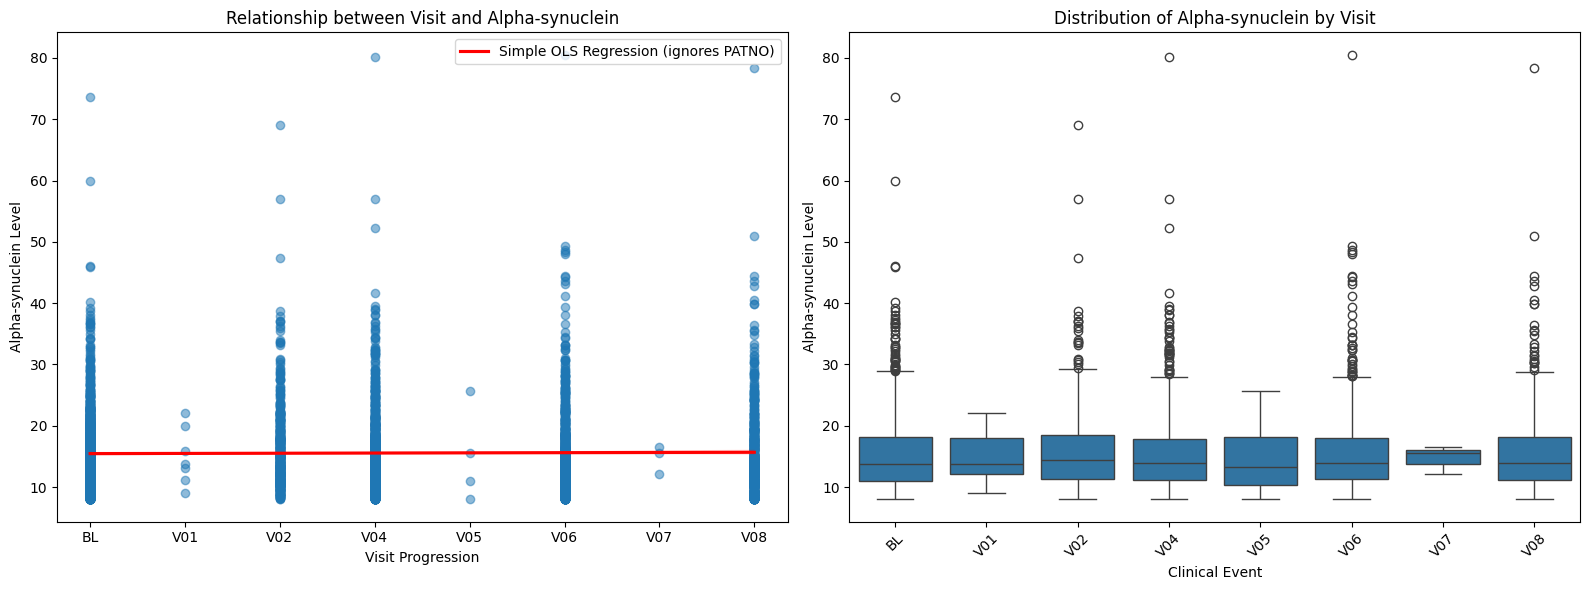

In [4]:
import numpy as np
import pandas as pd # Make sure pandas is imported if not already
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # Import statsmodels

# Define the visit order - CHECK if V03 is missing intentionally or exists in data
# If V03 exists and should be included, add it here and to the event_map
event_order = ['BL', 'V01', 'V02', 'V04', 'V05', 'V06', 'V07', 'V08']
event_map = {event: idx for idx, event in enumerate(event_order)}

# Create a copy to avoid modifying the original dataframe
ptau_analysis = blood_ptau.copy()

# Convert CLINICAL_EVENT to numeric and TESTVALUE to numeric
ptau_analysis['visit_numeric'] = ptau_analysis['CLINICAL_EVENT'].map(event_map)
ptau_analysis['TESTVALUE'] = pd.to_numeric(ptau_analysis['TESTVALUE'], errors='coerce')

# Drop rows with missing values needed for the analysis
# Note: LMMs can sometimes handle missing data better than dropping, but for simplicity here, we'll drop.
clean_data = ptau_analysis.dropna(subset=['visit_numeric', 'TESTVALUE', 'PATNO'])

# Check if there's enough data to proceed
if clean_data.empty or clean_data['visit_numeric'].nunique() < 2:
    print("Not enough valid data points or visits to perform the analysis.")
else:
    # --- Linear Mixed-Effects Model ---
    # We model TESTVALUE as a function of the visit progression (visit_numeric).
    # We include a random intercept for each PATNO to account for baseline differences
    # and the repeated measures structure.
    print("\n--- Linear Mixed-Effects Model Results ---")
    try:
        # Define and fit the model
        # Formula: TESTVALUE depends on visit_numeric (fixed effect)
        # Groups: Observations are grouped by PATNO
        # re_formula="~1": We fit a random intercept for each group (PATNO)
        lmm_formula = "TESTVALUE ~ visit_numeric"
        model = smf.mixedlm(lmm_formula, clean_data, groups=clean_data['PATNO'])
        result = model.fit()

        # Print the model summary
        print(result.summary())

        # --- Interpretation ---
        # Look at the 'Coef.' and 'P>|z|' for the 'visit_numeric' row.
        # Coef.: The estimated average change in TESTVALUE for each step increase in visit_numeric.
        # P>|z|: The p-value for the test that the coefficient is zero.
        visit_coef = result.params['visit_numeric']
        visit_pvalue = result.pvalues['visit_numeric']

        print("\n--- Interpretation of Visit Trend ---")
        print(f"Estimated change in TESTVALUE per visit step: {visit_coef:.4f}")
        print(f"P-value for visit trend: {visit_pvalue:.4f}")

        if visit_pvalue < 0.05:
            if visit_coef < 0:
                print("There is a statistically significant decrease in TESTVALUE over visits.")
            elif visit_coef > 0:
                print("There is a statistically significant increase in TESTVALUE over visits.")
            else:
                print("There is a statistically significant effect of visit, but the coefficient is near zero.")
        else:
            print("There is no statistically significant linear trend in TESTVALUE over visits.")

    except Exception as e:
        print(f"\nCould not fit the Linear Mixed-Effects Model. Error: {e}")
        print("This might happen if data structure is unsuitable (e.g., too few subjects per visit).")


    # --- Visualizations (still useful) ---
    print("\n--- Generating Visualizations ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Scatter plot with regression line (Note: line ignores repeated measures)
    sns.regplot(x='visit_numeric', y='TESTVALUE', data=clean_data, ax=ax1,
                line_kws={'color':'red', 'label':'Simple OLS Regression (ignores PATNO)'},
                scatter_kws={'alpha':0.5})
    ax1.set_xlabel('Visit Progression')
    ax1.set_ylabel('Alpha-synuclein Level')
    ax1.set_title('Relationship between Visit and Alpha-synuclein')
    ax1.set_xticks(range(len(event_order)))
    ax1.set_xticklabels(event_order)
    # Add LMM slope for comparison if desired (more advanced plotting)
    # x_vals = np.array(ax1.get_xlim())
    # y_vals = result.params['Intercept'] + result.params['visit_numeric'] * x_vals
    # ax1.plot(x_vals, y_vals, color='blue', linestyle='--', label='LMM Fixed Effect Trend')
    ax1.legend()


    # 2. Box plot to show distribution by visit
    sns.boxplot(x='CLINICAL_EVENT', y='TESTVALUE', data=clean_data, order=event_order, ax=ax2)
    ax2.set_xlabel('Clinical Event')
    ax2.set_ylabel('Alpha-synuclein Level')
    ax2.set_title('Distribution of Alpha-synuclein by Visit')
    plt.sca(ax2) # Set current axis for plt functions
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# --- END REPLACEMENT CELL ---